## Sentiment analysis

The purpose of this notebook is to analyze the sentiment of video game reviews using various NLP tools and to examine how well the sentiment of the review text correlates with the assigned review scores. By comparing methods such as VADER, TextBlob, and BERT-based models, I aim to determine if sentiment analysis reliably aligns with high or low review scores.







### Data Cleaning and preparation

Please uncomment the following code if you like to access the file directly in Colab from the Cloud.

In [2]:
# import gdown
# import pandas as pd

# # Updated file ID
# file_id = "1hCdsIfcWrWZtta4CJtMasvNRf9HE7GYk"

# # New download URL
# download_url = f"https://drive.google.com/uc?id={file_id}"

# output_file = 'downloaded_file.csv'
# gdown.download(download_url, output_file, quiet=False)

# # Load the new CSV into the DataFrame
# df = pd.read_csv(output_file)

Please use the following if you like to access the csv file locally, and change the path accordingly.

In [3]:
import pandas as pd

file_path = "/teamspace/studios/this_studio/Project/Final files updated/gamespot_reviews_complete.csv"

df = pd.read_csv(file_path)

First, I will preprocess the text by performing cleaning, tokenization, stopword removal, and lemmatization. Next, I will run the various models mentioned earlier and then visualize their performance to see how well each sentiment score correlates with the game review score. Additionally, I will analyze the results to assess correlation strength, evaluate whether deep learning models performed better, and discuss whether the correlations align logically with the review scores.

#### Preprocessing Review Text: Cleaning, Tokenization, Stopword Removal, and Lemmatization

In [4]:
# Import necessary libraries
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# NLTK resources using default paths for scalability
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Text Preprocessing
# Convert review text to lowercase and remove punctuation
df['Review_Cleaned'] = df['Review'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

# Tokenization, Stopword Removal, and Lemmatization
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply the preprocessing steps
df['Tokens'] = df['Review_Cleaned'].apply(lambda text: [
    lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words
])

# Display the final DataFrame with the preprocessed text and tokens
df[['Review', 'Review_Cleaned', 'Tokens']].head()


,Review,Review_Cleaned,Tokens
0,Nintendo's party loses a little luster in its ...,nintendos party loses a little luster in its a...,"[nintendos, party, loses, little, luster, atte..."
1,The classic children's sports gaming franchise...,the classic childrens sports gaming franchise ...,"[classic, childrens, sport, gaming, franchise,..."
2,The frenetic fighting Dragon Ball fans expect ...,the frenetic fighting dragon ball fans expect ...,"[frenetic, fighting, dragon, ball, fan, expect..."
3,The Vessel of Hatred expansion meaningfully ex...,the vessel of hatred expansion meaningfully ex...,"[vessel, hatred, expansion, meaningfully, expa..."
4,Remaking one of the most revered horror games ...,remaking one of the most revered horror games ...,"[remaking, one, revered, horror, game, ever, s..."


### Runnings different models to compare sentiment score

Environment Setup and GPU Configuration

In [5]:
# Import necessary libraries
import os
import torch

# Set up GPU configuration
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = 0 if torch.cuda.is_available() else -1
print(f"GPU is available: {torch.cuda.is_available()} (Using device: {'GPU' if device == 0 else 'CPU'})")


GPU is available: True (Using device: GPU)


VADER Sentiment Analysis with Custom Lexicon

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Update VADER lexicon with custom terms for better accuracy
custom_lexicon = {
    'not good': -3.0,
    'barely playable': -2.5,
    'fantastic': 3.0,
    'must buy': 3.5,
    'waste of time': -4.0
}
analyzer.lexicon.update(custom_lexicon)

# Apply VADER sentiment analysis to calculate sentiment score
df['Sentiment'] = df['Review'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Categorize sentiment as positive, neutral, or negative
def categorize_sentiment(score, pos_threshold=0.7, neg_threshold=-0.7):
    if score >= pos_threshold:
        return 'positive'
    elif score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment_Category'] = df['Sentiment'].apply(categorize_sentiment)


TextBlob Sentiment Analysis

In [7]:
from textblob import TextBlob

# Apply TextBlob sentiment analysis to calculate polarity score
df['TextBlob_Sentiment'] = df['Review'].apply(lambda text: TextBlob(text).sentiment.polarity)


Transformer-Based Sentiment Analysis Pipelines

In [8]:
from transformers import pipeline

# Initialize sentiment analysis pipelines with GPU support
bert_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device)
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=device)
review_classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)


2024-10-29 09:45:07.093668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 09:45:07.164115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 09:45:07.186790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 09:45:07.327485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 09:45:08.602829: W tensorflow/compiler/tf2

Functions for Each Transformer-Based Model


In [9]:
# Define function for DistilBERT sentiment analysis
def get_distilbert_sentiment(review_text):
    result = bert_classifier(review_text, max_length=512, truncation=True)
    return 1 if result[0]['label'] == 'POSITIVE' else -1

# Define function for RoBERTa sentiment analysis
def get_roberta_sentiment(review_text):
    try:
        result = roberta_classifier(review_text, max_length=512, truncation=True)
        return {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}.get(result[0]['label'], np.nan)
    except Exception as e:
        print(f"Error processing review: {review_text[:30]}... - {str(e)}")
        return np.nan

# Define function for Multilingual BERT sentiment analysis
def get_review_sentiment(review_text):
    result = review_classifier(review_text, max_length=512, truncation=True)
    sentiment_map = {'1 star': -2, '2 stars': -1, '3 stars': 0, '4 stars': 1, '5 stars': 2}
    return sentiment_map.get(result[0]['label'], np.nan)


Transformer-Based Sentiment Functions

In [12]:
import numpy as np


In [13]:
# Apply the sentiment functions to get numerical sentiment scores
df['DistilBERT_Sentiment_Num'] = df['Review'].apply(get_distilbert_sentiment)
df['RoBERTa_Sentiment_Num'] = df['Review'].apply(get_roberta_sentiment)
df['Review_Sentiment_Num'] = df['Review'].apply(get_review_sentiment)


### Visualizing Correlation Between Review Scores and Different Sentiment Analysis Methods

Correlation of Score with Sentiment Analysis Methods:
Score                1.000000
VADER                0.359982
TextBlob             0.572628
RoBERTa              0.552927
DistilBERT           0.587268
Multilingual_BERT    0.680885
Name: Score, dtype: float64


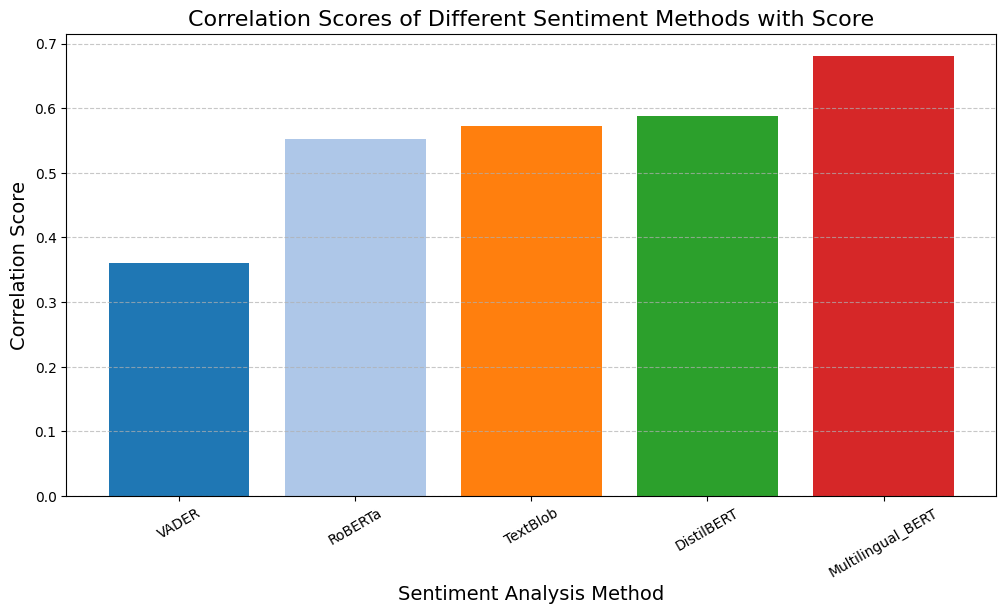

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename columns for clarity
df = df.rename(columns={
    'Sentiment': 'VADER',
    'TextBlob_Sentiment': 'TextBlob',
    'RoBERTa_Sentiment_Num': 'RoBERTa',
    'DistilBERT_Sentiment_Num': 'DistilBERT',
    'Review_Sentiment_Num': 'Multilingual_BERT'
})

# Define the sentiment columns with the new names
sentiment_columns = [
    'VADER', 'TextBlob', 'BERT_Sentiment_Num', 'RoBERTa', 'DistilBERT', 'Multilingual_BERT',
    'Review_Sentiment_Adjusted', 'Review_Sentiment_Num_Cleaned', 'Review_Sentiment_Num_Tokens'
]

# Convert relevant columns to numeric format
for col in sentiment_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, set errors to NaN if necessary

# Calculate the correlation matrix for sentiment columns and `Score`
relevant_columns = ['Score'] + [col for col in sentiment_columns if col in df.columns]
correlations = df[relevant_columns].corr()

# Display the correlation of each sentiment method with the `Score`
print("Correlation of Score with Sentiment Analysis Methods:")
print(correlations['Score'])

# Filter and visualize correlation (excluding 'Score' itself)
filtered_correlations = correlations['Score'].drop(['Score'], errors='ignore')
sorted_correlation = filtered_correlations.sort_values()

# Bar plot for the sorted correlation values
plt.figure(figsize=(12, 6))
plt.bar(sorted_correlation.index, sorted_correlation.values,
        color=['#1f77b4', '#aec7e8', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
plt.title('Correlation Scores of Different Sentiment Methods with Score', fontsize=16)
plt.xlabel('Sentiment Analysis Method', fontsize=14)
plt.ylabel('Correlation Score', fontsize=14)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Interpreting Results

The Multilingual BERT model performs significantly better than other models, showing a strong correlation of 0.68 between score and sentiment, outperforming other BERT models as well as baseline models like VADER and TextBlob. This correlation suggests that higher scores generally align with positive sentiment, while lower scores align with negative sentiment. This outcome was expected, as transformer models capture text nuances effectively, enabling a deeper understanding of whether a review is positive, neutral, or negative.

Visualizing Average Normalized Sentiment from Multilingual BERT (Review_Sentiment_Num) Across Score Ranges

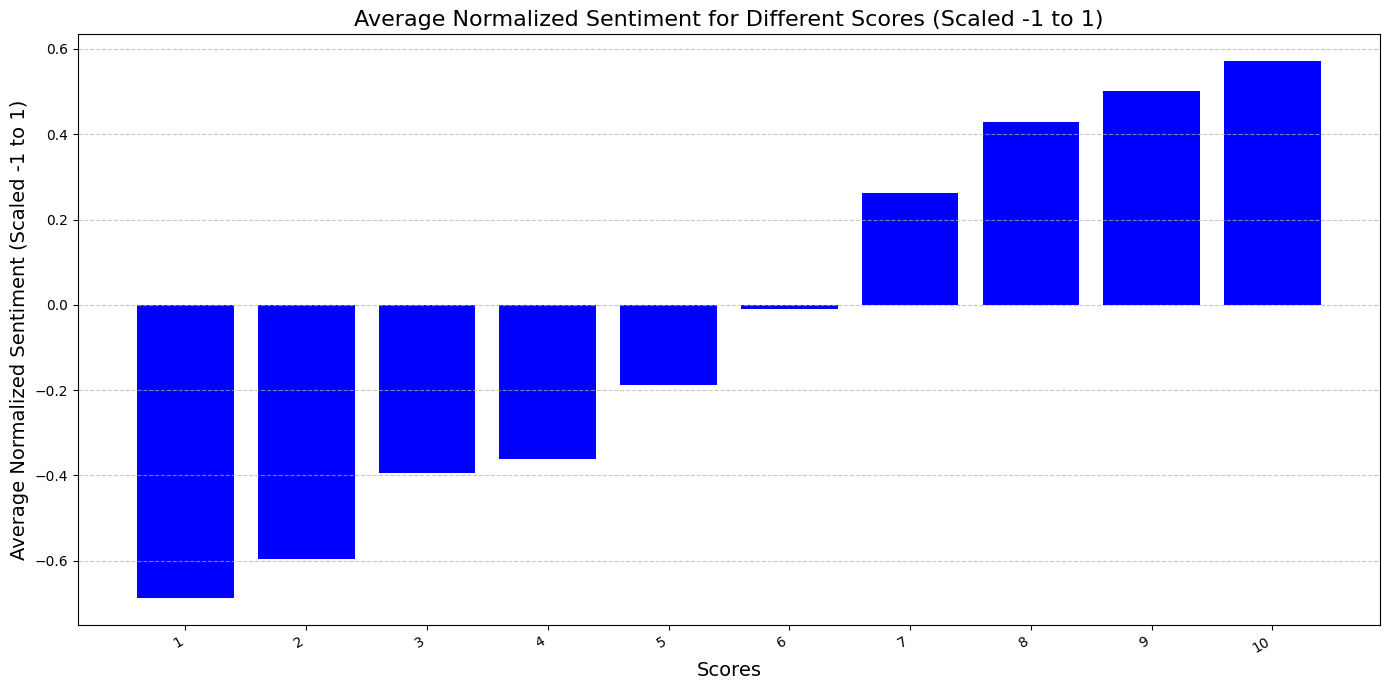

In [18]:
# 6. Normalize the 'Review_Sentiment_Num' column
if 'Review_Sentiment_Num' in df.columns:
    # Normalize `Review_Sentiment_Num` to range -1 to 1 using MinMaxScaler
    df['Normalized_Sentiment'] = MinMaxScaler(feature_range=(-1, 1)).fit_transform(df[['Review_Sentiment_Num']])

    # 7. Define score ranges for grouping
    ranges = [
        (9.5, 10, "10"), (8.5, 9.5, "9"), (7.5, 8.5, "8"), (6.5, 7.5, "7"),
        (5.5, 6.5, "6"), (4.5, 5.5, "5"), (3.5, 4.5, "4"), (2.5, 3.5, "3"),
        (1.5, 2.5, "2"), (0.5, 1.5, "1")
    ]

    # 8. Calculate the average normalized sentiment for each range
    score_range_data = {}
    for lower, upper, label in ranges:
        average_sentiment = df[(df['Score'] >= lower) & (df['Score'] < upper)]['Normalized_Sentiment'].mean()
        score_range_data[label] = average_sentiment

    # 9. Convert the dictionary to a DataFrame and sort by the average sentiment values
    score_range_df = pd.DataFrame(list(score_range_data.items()), columns=["Score", "Average Sentiment"])
    sorted_score_df = score_range_df.set_index("Score").sort_values("Average Sentiment", ascending=True)

    # 10. Create a bar plot for the average sentiment values per score range
    plt.figure(figsize=(14, 7))
    plt.bar(sorted_score_df.index, sorted_score_df['Average Sentiment'], color='blue')
    plt.title('Average Normalized Sentiment for Different Scores (Scaled -1 to 1)', fontsize=16)
    plt.xlabel('Scores', fontsize=14)
    plt.ylabel('Average Normalized Sentiment (Scaled -1 to 1)', fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("The 'Review_Sentiment_Num' column does not exist in the DataFrame.")


On deeper analysis of the Multilingual BERT model, which showed the highest correlation between score and review sentiment, we can see this relationship clearly in the bar plot. The plot illustrates that negative review scores generally correspond to a negative sentiment, while higher scores correspond to a positive sentiment. This trend is reflected in the normalized sentiment scale, ranging from -1 to 1, with 0 representing a neutral sentiment.